In [47]:
# Get everything setup for dedicated module loading

%load_ext autoreload
%autoreload 2
from renault.plot import *
from renault.get_data import get_pji_with_misssing_fluids_measure
from renault.knn_preprocessing import preprocess_data, datetime_reshaping
from renault.feature_engineering import feature_engineering


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np 
import pandas as pd
import datetime 

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from sklearn.cluster import KMeans

import plotly.graph_objects as go
import plotly.express as px

# Data Analysis Check

In [7]:
df = pd.read_csv('../data/train_df_LHA.csv',index_col='Unnamed: 0' )
filling = ['ActVolume', 'ActMass']
STEPS = ['StepLoading', 'StepEndLoading']

In [54]:
most_common_df = datetime_reshaping(df)
most_common_df

,siteCode,objectUAI,machine,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type,time,delta
310695,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:29.625000+00:00,810451,68.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:29.625000+00:00,0.000
313513,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:41.828000+00:00,810451,345.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:41.828000+00:00,12.203
305805,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:46.437000+00:00,810451,474.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:46.437000+00:00,4.609
310693,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:48.937000+00:00,810451,474.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:48.937000+00:00,2.500
315053,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:52.937000+00:00,810451,481.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:52.937000+00:00,4.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155787,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:37.640000+00:00,740170,1392.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:37.640000+00:00,0.781
162288,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:38.859000+00:00,740170,1393.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:38.859000+00:00,1.219
169504,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:40.359000+00:00,740170,1394.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:40.359000+00:00,1.500
152151,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:42.531000+00:00,740170,1395.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:42.531000+00:00,2.172


Number of steps for each type of measurements

In [9]:
df[df.measurement.isin(filling)].groupby(['fluid','pji', 'step', 'measurement'], as_index=False) \
    .agg({'dataValue': 'describe'}) \
    .groupby(['fluid',  'measurement','step']) \
    .count()

/Users/alix/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


pji dataValue                             
                                           count mean std min 25% 50% 75% max
fluid   measurement step                                                     
FRFluid ActVolume   StepEndLoading  42        42   42  25  42  42  42  42  42
                    StepLoading     58        58   58  58  58  58  58  58  58
RMFluid ActVolume   StepEndLoading   5         5    5   1   5   5   5   5   5
                    StepLoading     58        58   58  58  58  58  58  58  58

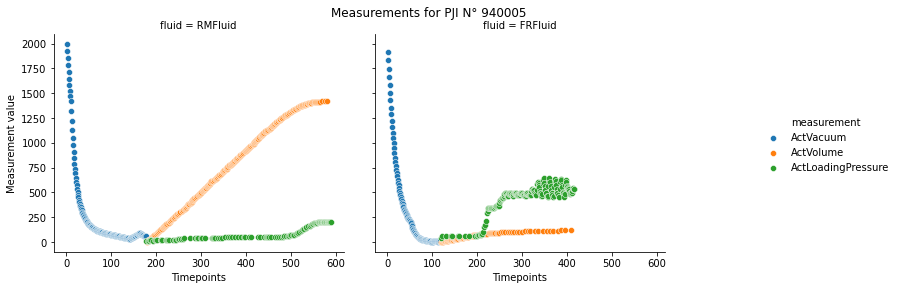

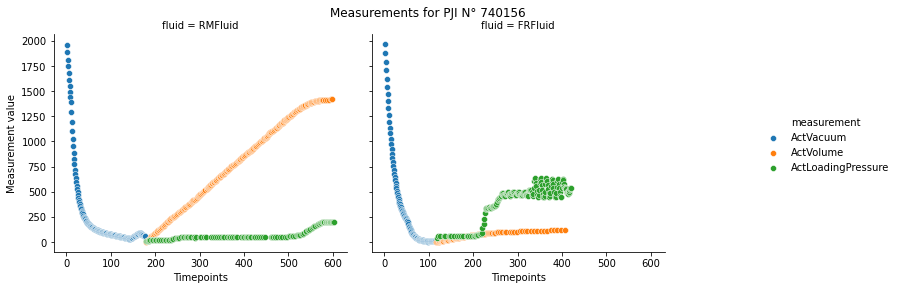

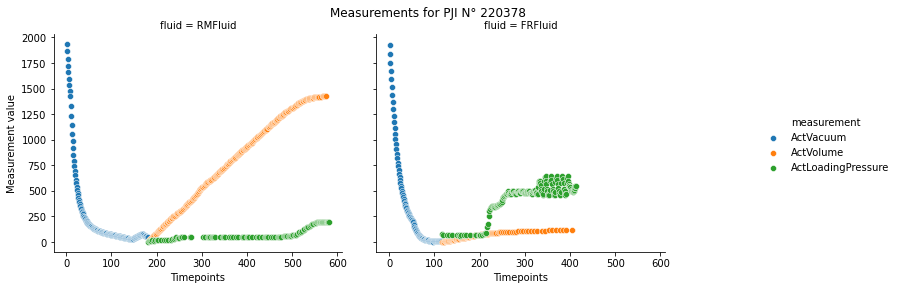

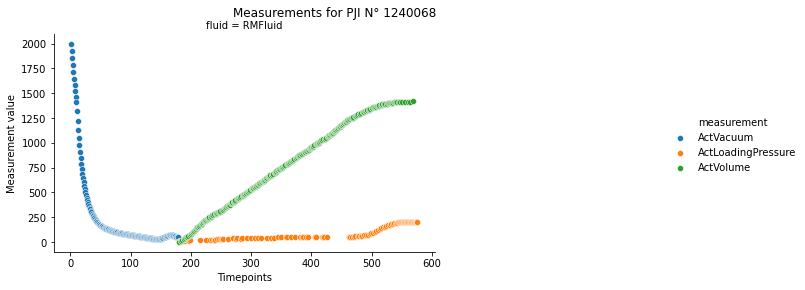

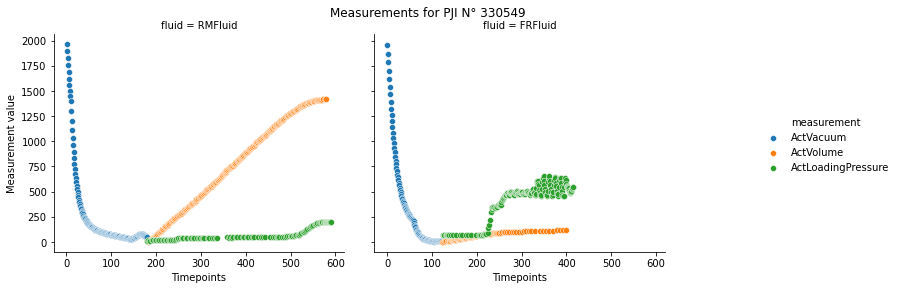

In [10]:
for num in np.random.choice(df.pji.unique(), 5):
    plot_all_fluid(df,num)

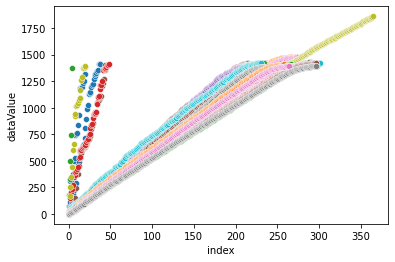

In [11]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'RMFluid', 'ActVolume')

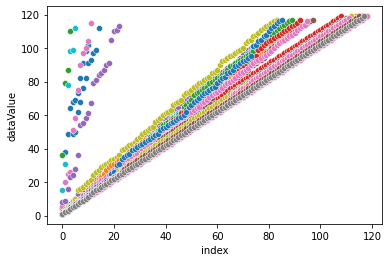

In [12]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'FRFluid', 'ActVolume')

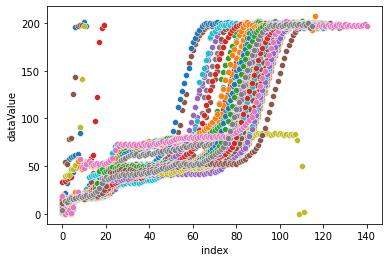

In [13]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'RMFluid', 'ActLoadingPressure')

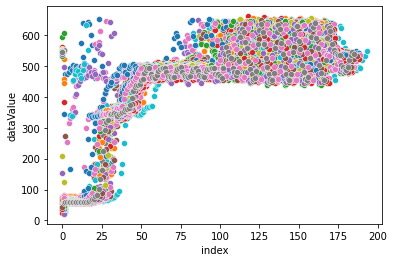

In [14]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'FRFluid', 'ActLoadingPressure')

In [15]:
df[(df.dataValue > 1500) & (df.measurement == 'ActVolume') ]['pji'].unique()

array([4620256])

# model fit

In [55]:
# Global organisation of the data
# remove pji without 3 fluids and 3 measurements
most_common_df = most_common_df[most_common_df['measurement'] != 'ActVacuum']
bad_pji = get_pji_with_misssing_fluids_measure(most_common_df, 2, 2)
most_common_df = most_common_df[~most_common_df.pji.isin(bad_pji)]

final_df = feature_engineering(most_common_df)

In [56]:
final_df

,"(dataValue, FRFluid, ActLoadingPressure)","(dataValue, FRFluid, ActVolume)","(dataValue, RMFluid, ActLoadingPressure)","(dataValue, RMFluid, ActVolume)","((delta, count), FRFluid, ActLoadingPressure)","((delta, count), FRFluid, ActVolume)","((delta, count), RMFluid, ActLoadingPressure)","((delta, count), RMFluid, ActVolume)","((delta, mean), FRFluid, ActLoadingPressure)","((delta, mean), FRFluid, ActVolume)",...,"(90%, FRFluid, ActLoadingPressure)","(90%, FRFluid, ActVolume)","(90%, RMFluid, ActLoadingPressure)","(90%, RMFluid, ActVolume)","(max, FRFluid, ActLoadingPressure)","(max, FRFluid, ActVolume)","(max, RMFluid, ActLoadingPressure)","(max, RMFluid, ActVolume)",FRFluid,RMFluid
pji,,,,,,,,,,,,,,,,,,,,,
130567,536.333333,117.000000,198.333333,1421.000000,179,115,107,296,0.252531,0.377174,...,591.4,106.6,198.0,1370.5,646.0,118.0,200.0,1422.0,1,2
220378,540.333333,118.000000,198.000000,1426.000000,181,116,110,291,0.250779,0.379991,...,593.0,107.5,198.0,1378.0,650.0,119.0,200.0,1427.0,1,2
310143,517.666667,117.000000,197.000000,1389.000000,186,115,113,254,0.241349,0.365217,...,577.5,106.6,198.0,1339.6,645.0,118.0,202.0,1390.0,1,2
310167,529.333333,118.000000,199.000000,1417.000000,185,109,108,291,0.244849,0.409266,...,583.2,108.2,198.0,1369.0,648.0,119.0,200.0,1418.0,1,2
310586,537.333333,117.000000,198.000000,1420.000000,194,115,120,299,0.233005,0.383296,...,589.7,106.6,198.0,1367.6,647.0,118.0,200.0,1421.0,1,2
320115,544.666667,117.000000,198.666667,1420.000000,184,115,116,294,0.249408,0.367800,...,585.7,106.6,198.5,1372.1,650.0,118.0,201.0,1421.0,1,2
320294,536.333333,117.000000,199.000000,1421.000000,183,117,112,299,0.246929,0.379402,...,577.4,106.4,198.0,1368.6,644.0,118.0,200.0,1422.0,1,2
330063,541.000000,117.000000,198.000000,1398.000000,181,111,111,279,0.249746,0.399910,...,572.0,107.0,199.0,1349.6,643.0,118.0,200.0,1399.0,2,1
330549,543.333333,117.000000,196.666667,1418.000000,179,114,120,291,0.251480,0.371851,...,594.2,106.7,198.0,1362.0,651.0,118.0,200.0,1419.0,1,2


## Simple KNN detection

In [57]:
pipe = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='constant', fill_value=-5)
)
pipe.fit(final_df)
X = pipe.transform(final_df)

near = NearestNeighbors(n_neighbors=10)
near.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

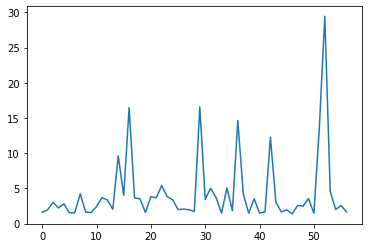

In [58]:
# distances and indexes of k-neaighbors from model outputs
distances, indexes = near.kneighbors(X)# plot mean of k-distances of each observation
plt.plot(distances.mean(axis =1))

pji
5020123    29.457757
810451     16.585058
620543     16.502508
1010403    14.639673
4620256    13.680514
1110525    12.278599
610625      9.609404
650183      5.407881
911115      5.071401
810589      5.020552
dtype: float64

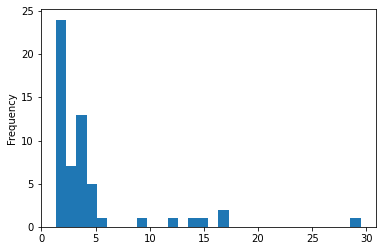

In [59]:
proximity = pd.Series(distances.mean(axis =1))
proximity.index = final_df.index
proximity.plot.hist(bins=30)

threshold = 5
proximity = proximity.sort_values(ascending=False)
proximity = proximity[proximity > threshold]
proximity

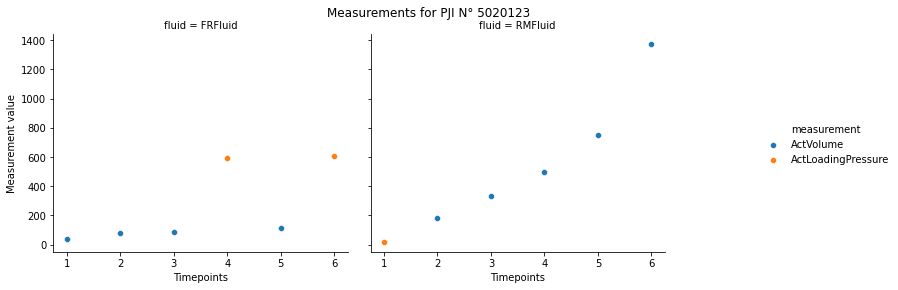

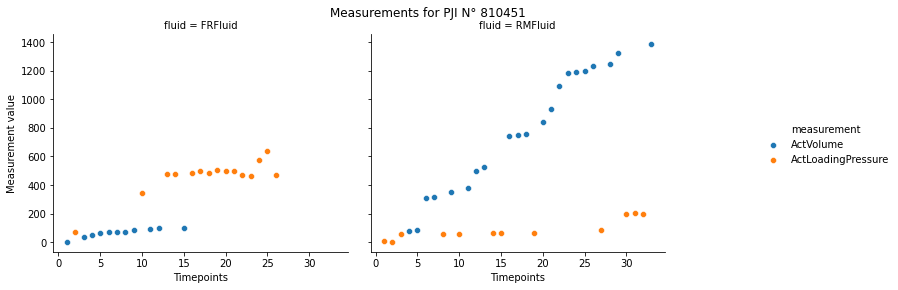

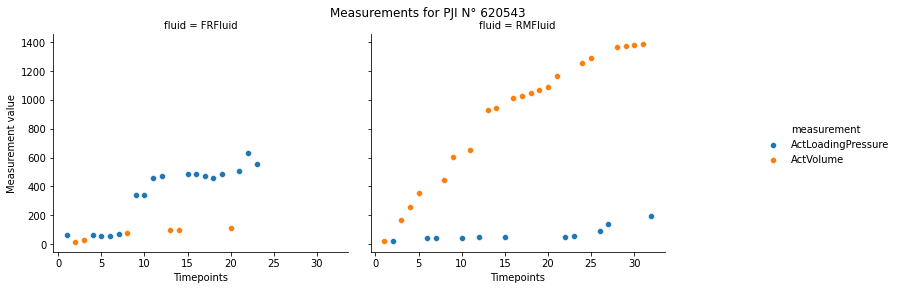

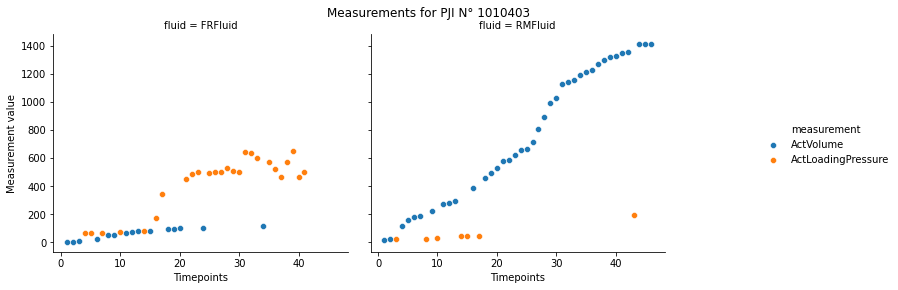

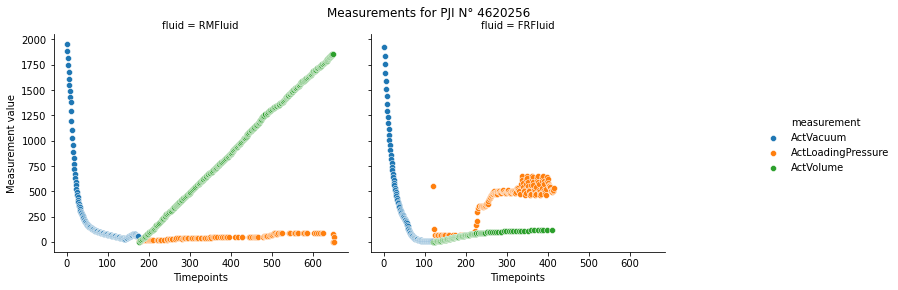

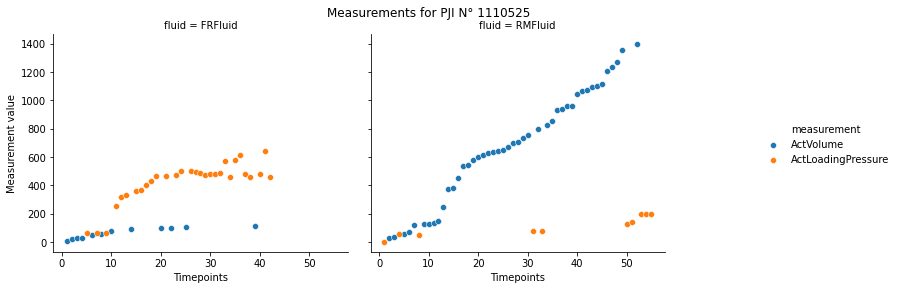

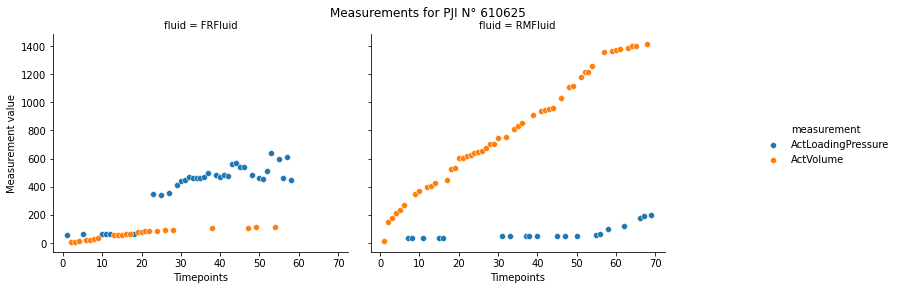

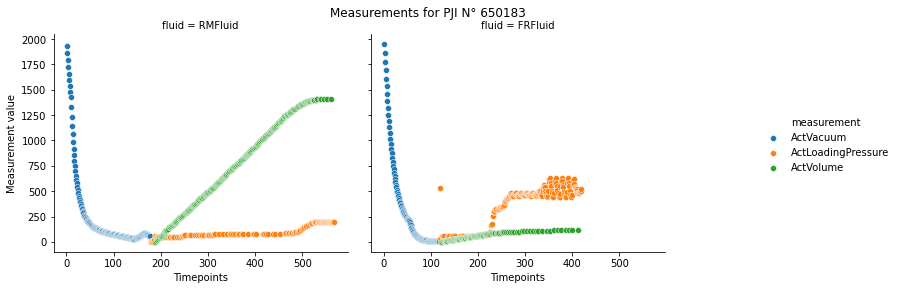

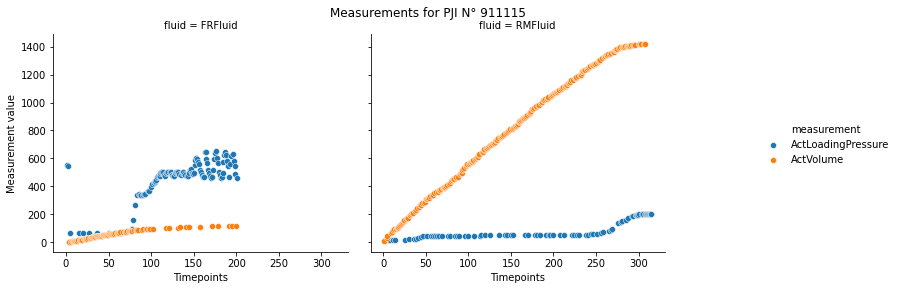

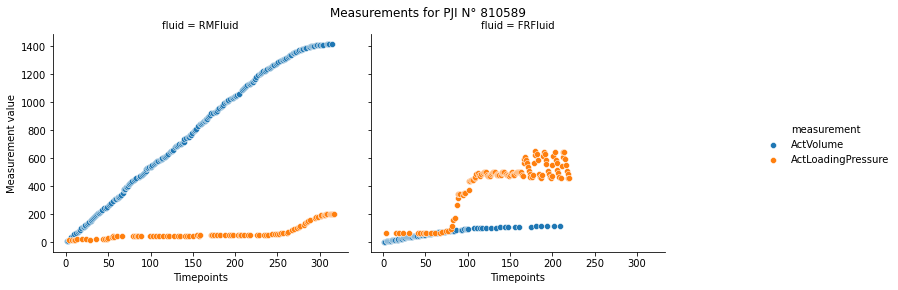

In [60]:
for pji in proximity.index:
    plot_all_fluid(df, pji)

## Isolation Forest Detection

In [23]:
isof = IsolationForest(n_jobs=-1)
isof.fit(X)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=-1, random_state=None, verbose=0, warm_start=False)

In [24]:
isof_anomaly = final_df[list(isof.predict(X) == -1)].index
isof_anomaly

Int64Index([610625, 620543, 810451, 1010403, 1110525, 4620256, 5020123], dtype='int64', name='pji')

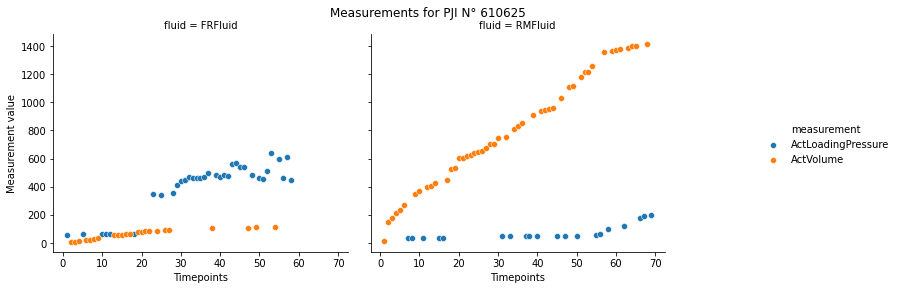

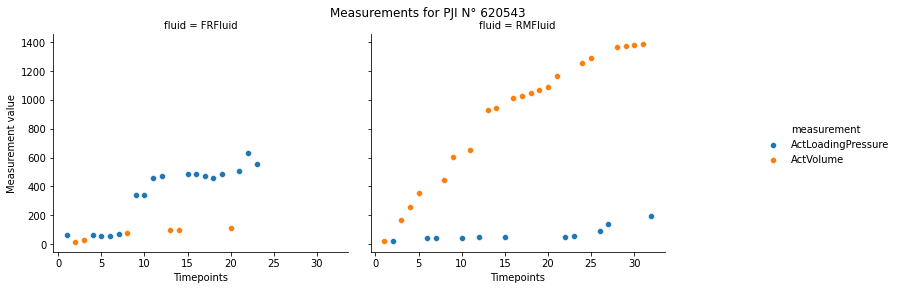

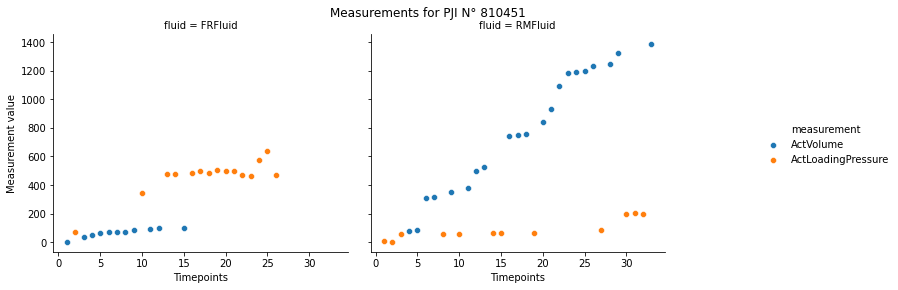

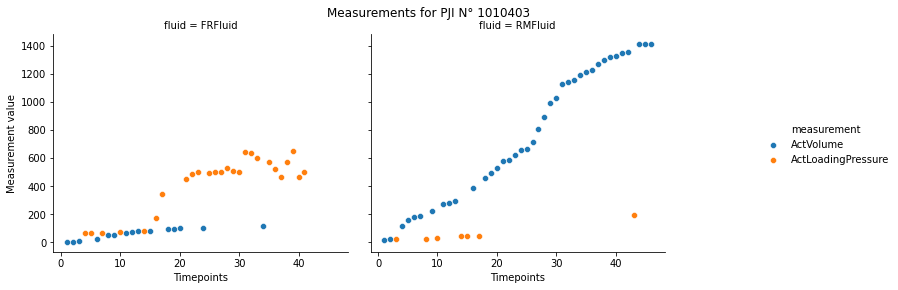

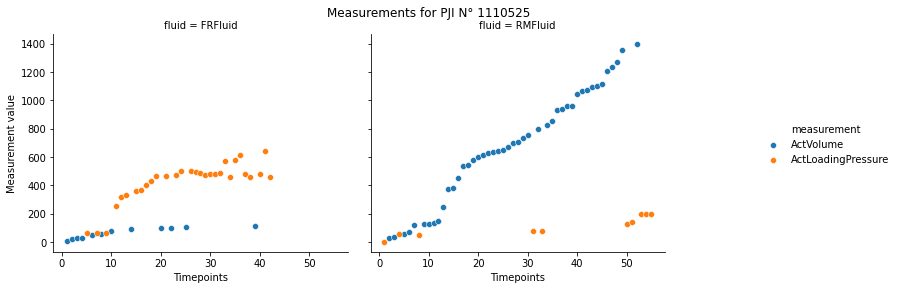

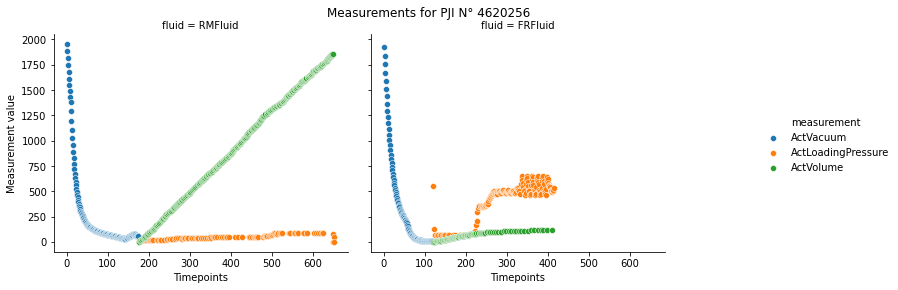

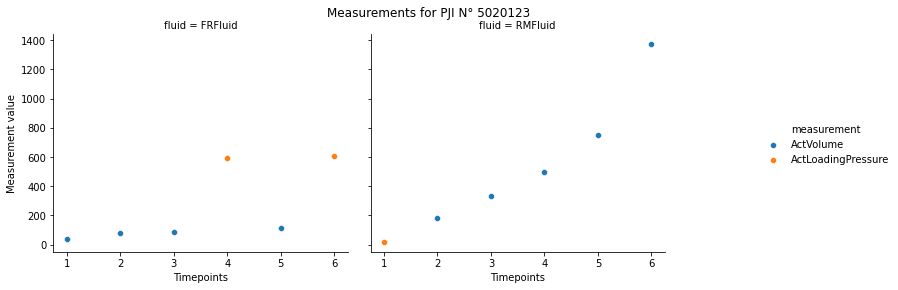

In [25]:
for pji in isof_anomaly:
    plot_all_fluid(df, pji)

# Evaluation on inference dataset

In [26]:
test = pd.read_csv('../data/inference_df_LHA.csv')

test = test.dropna()
test

,Unnamed: 0,siteCode,objectUAI,machine,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type
0,2,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-28 10:50:38.687000+00:00,4730232.0,823.0,F82,DG,BVM6,NOT_HYBRID,M9R
1,3,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:51.906000+00:00,4730232.0,610.0,F82,DG,BVM6,NOT_HYBRID,M9R
2,5,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActVolume,StepLoading,2021-01-28 11:04:23.796000+00:00,5230145.0,31.0,F82,DG,BVM6,NOT_HYBRID,M9R
3,11,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-28 11:04:29.703000+00:00,5230145.0,309.0,F82,DG,BVM6,NOT_HYBRID,M9R
4,24,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-28 10:50:40.796000+00:00,4730232.0,920.0,F82,DG,BVM6,NOT_HYBRID,M9R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60281,110428,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActVacuum,StepVacuumControl,2021-02-01 15:18:46.968000+00:00,610521.0,4.0,F82,DG,BVM6,NOT_HYBRID,M9R
60282,110430,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVacuum,StepVacuumControl,2021-02-01 04:59:40.046000+00:00,520368.0,42.0,F82,DG,BVM6,NOT_HYBRID,M9R
60283,110431,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVacuum,StepVacuumControl,2021-02-01 16:07:25.140000+00:00,610490.0,61.0,F82,DG,BVM6,NOT_HYBRID,M9R
60284,110434,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActVacuum,StepVacuumControl,2021-02-01 19:04:24.843000+00:00,610496.0,7.0,F82,DG,BVM6,NOT_HYBRID,M9R


In [27]:
test_reshaped = datetime_reshaping(test)
test_reshaped.head()

,Unnamed: 0,siteCode,objectUAI,machine,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type,time,delta
1261,8336,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:18.296000+00:00,4730232.0,540.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:18.296000+00:00,0.000
737,3557,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:18.687000+00:00,4730232.0,42.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:18.687000+00:00,0.391
865,4446,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:18.906000+00:00,4730232.0,60.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:18.906000+00:00,0.219
784,3877,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:19.093000+00:00,4730232.0,61.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:19.093000+00:00,0.187
494,2199,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:19.406000+00:00,4730232.0,62.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:19.406000+00:00,0.313


In [61]:
test_reshaped = test_reshaped[test_reshaped['measurement'] != 'ActVacuum']
bad_pji = get_pji_with_misssing_fluids_measure(test_reshaped, 2, 2)
# Global organisation of the data
# remove pji without 3 fluids and 3 measurements
#bad_pji = get_pji_with_misssing_fluids_measure(test_reshaped)
test_reshaped = test_reshaped[~test_reshaped.pji.isin(bad_pji)]


test_final_df = feature_engineering(test_reshaped)
test_final_df

,"(dataValue, FRFluid, ActLoadingPressure)","(dataValue, FRFluid, ActVolume)","(dataValue, RMFluid, ActLoadingPressure)","(dataValue, RMFluid, ActVolume)","((delta, count), FRFluid, ActLoadingPressure)","((delta, count), FRFluid, ActVolume)","((delta, count), RMFluid, ActLoadingPressure)","((delta, count), RMFluid, ActVolume)","((delta, mean), FRFluid, ActLoadingPressure)","((delta, mean), FRFluid, ActVolume)",...,"(90%, FRFluid, ActLoadingPressure)","(90%, FRFluid, ActVolume)","(90%, RMFluid, ActLoadingPressure)","(90%, RMFluid, ActVolume)","(max, FRFluid, ActLoadingPressure)","(max, FRFluid, ActVolume)","(max, RMFluid, ActLoadingPressure)","(max, RMFluid, ActVolume)",FRFluid,RMFluid
pji,,,,,,,,,,,,,,,,,,,,,
340192.0,551.000000,117.0,198.333333,1420.000000,183,114,121,290,0.247011,0.371018,...,601.8,106.7,198.0,1371.3,651.0,118.0,200.0,1421.0,1,2
340207.0,521.666667,117.0,198.333333,1416.000000,182,115,118,302,0.246137,0.381661,...,589.8,106.6,199.0,1368.6,639.0,118.0,201.0,1417.0,1,2
340369.0,523.333333,113.0,197.000000,1419.000000,189,109,112,273,0.237106,0.383606,...,581.2,103.2,198.0,1371.4,649.0,114.0,199.0,1420.0,1,2
340371.0,529.000000,116.0,197.000000,1419.000000,187,112,123,289,0.242230,0.374027,...,582.8,105.9,198.0,1376.4,647.0,117.0,200.0,1420.0,1,2
350077.0,521.666667,117.0,197.666667,1420.000000,182,116,131,299,0.250516,0.366379,...,593.7,106.5,198.0,1370.6,641.0,118.0,201.0,1421.0,1,2
350160.0,536.666667,117.0,197.333333,1416.000000,182,116,130,290,0.249484,0.383750,...,588.5,106.5,198.0,1367.6,645.0,118.0,200.0,1417.0,1,2
350285.0,540.000000,116.0,198.333333,1417.000000,183,110,123,283,0.245902,0.392618,...,582.8,106.1,198.0,1370.4,643.0,117.0,201.0,1418.0,1,2
410104.0,520.333333,117.0,198.666667,1420.000000,182,112,128,288,0.246736,0.386857,...,586.7,106.9,198.3,1368.9,642.0,118.0,202.0,1421.0,1,2
410123.0,543.666667,113.0,196.666667,1423.000000,185,108,124,279,0.244508,0.388019,...,596.6,103.3,198.0,1373.6,649.0,114.0,199.0,1424.0,1,2


## KNN detection

In [62]:
X_test = pipe.transform(test_final_df)

In [63]:
X.shape, X_test.shape

((57, 58), (60, 58))

In [87]:
loc  = LocalOutlierFactor(n_neighbors=10, novelty=True ).fit(X)

In [88]:
loc.predict(X)

array([ 1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1, -1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  1,
       -1,  1, -1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1, -1,  1,  1,  1])

In [89]:
loc.predict(X_test)

array([ 1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,
        1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1])

In [90]:
loc_test_anomaly = loc.predict(X_test)

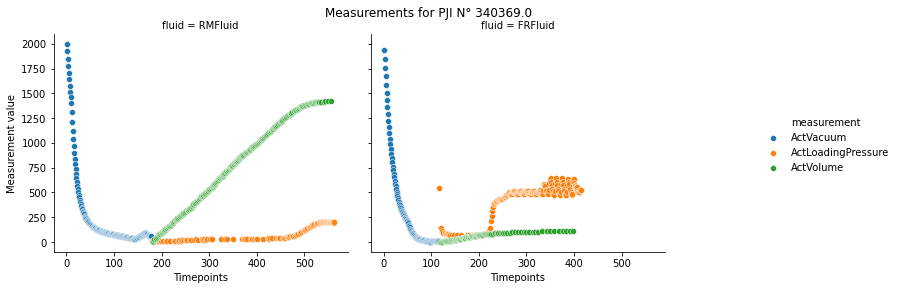

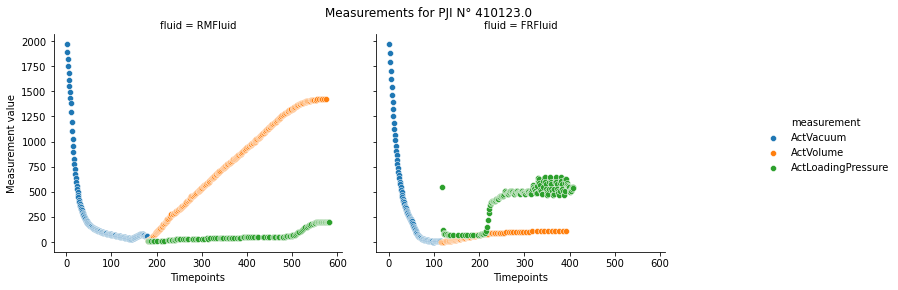

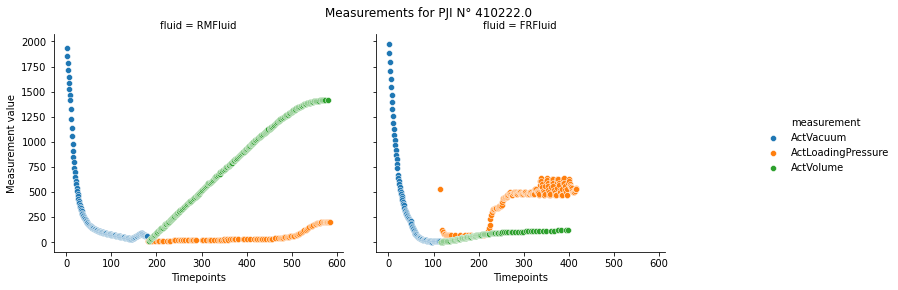

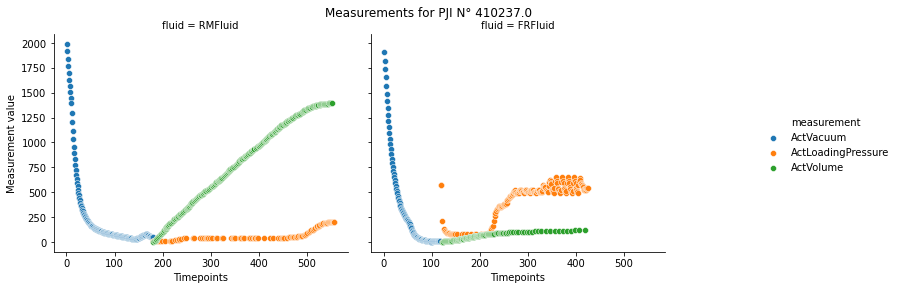

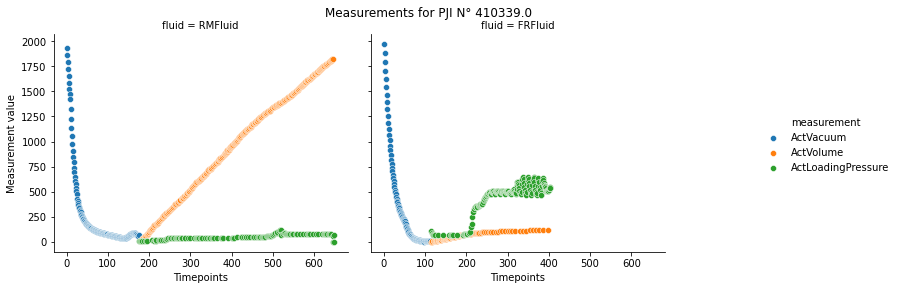

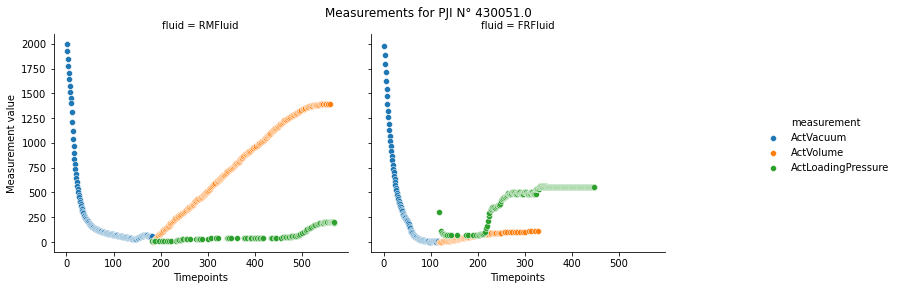

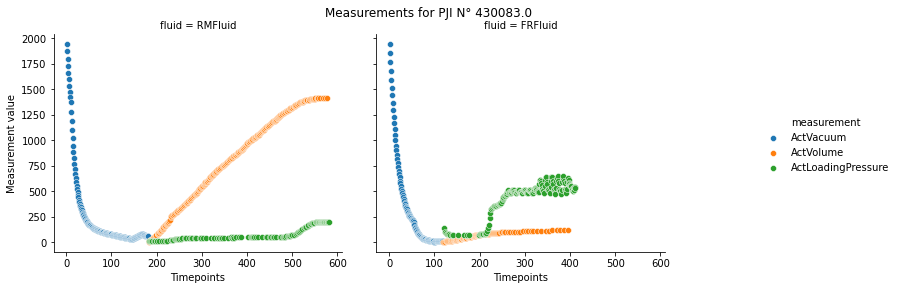

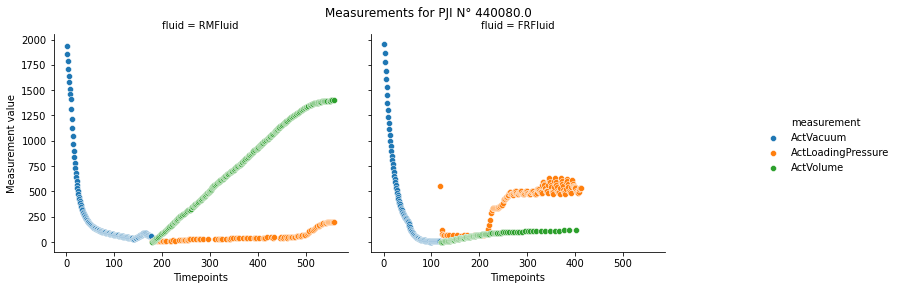

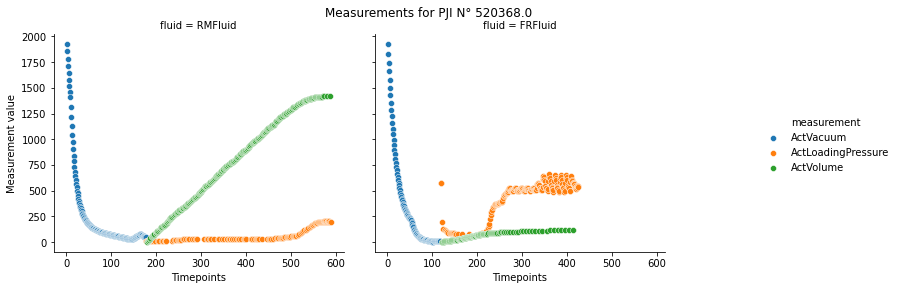

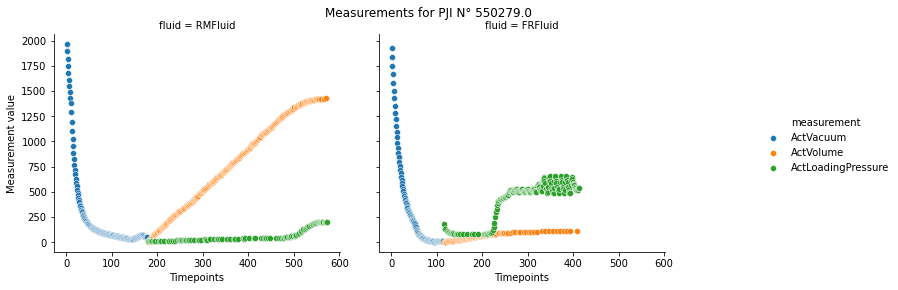

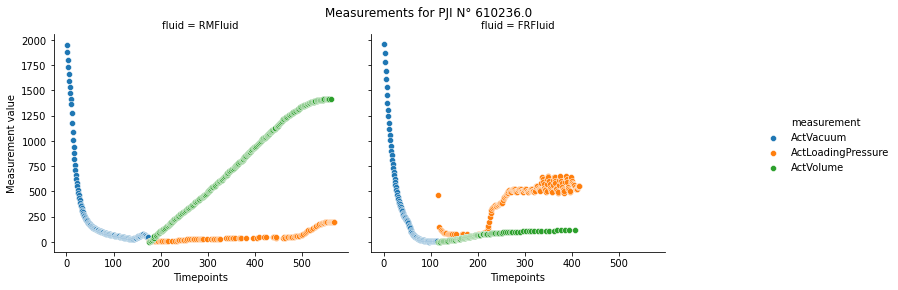

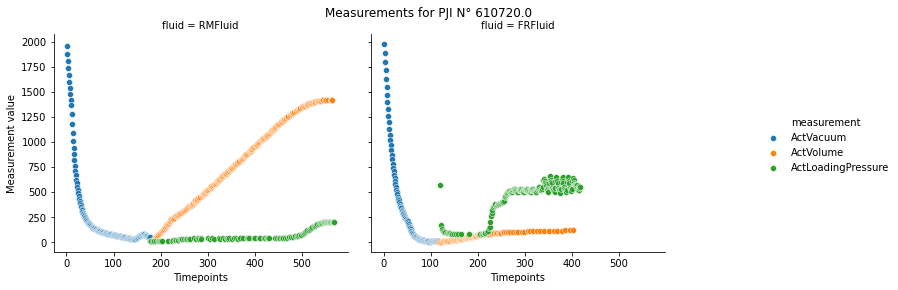

In [91]:
for pji in test_final_df[loc_test_anomaly == -1].index:
    plot_all_fluid(test, pji)

In [ ]:
for pji in test_proximity.index:
    plot_all_fluid(test, pji)

## Isolation forest detection

In [ ]:
test_anomaly = test_final_df[isof.predict(X_test) == -1].index
set(test_proximity.index) - set(test_anomaly)

In [ ]:
isof.score_samples(X_test)- isof.score_samples(X_test).mean()

# Case of Junary 29th

Jump from 28/01 to 01/02

In [ ]:
case = test[test.time.dt.month == 1]

In [ ]:
for pji in case.pji.unique()[:5]:
    plot_all_fluid(test, pji)

In [ ]:
case = df.groupby('pji')['time'].mean().reset_index().tail()['pji']

In [ ]:
for pji in case:
    plot_all_fluid(df, pji)

In [ ]:
temp = df.groupby(['pji', 'fluid'])['time'].min().reset_index()
temp = pd.pivot(temp, index=['pji'],values=['time'], columns=['fluid'])

In [ ]:
temp.columns = ['FR', 'RM']

In [ ]:
dfafter= test_reshaped[test_reshaped.time.dt.date != pd.to_datetime('2021-01-28')]

In [ ]:
df28.groupby(['pji', 'fluid', 'measurement'])['dataValue'].count()

In [ ]:
dfafter.groupby(['pji', 'fluid', 'measurement'])['dataValue'].count().reset_index()\
.groupby(['pji'])['dataValue'].count()